# Representation Learning using Auto Encoders

In [118]:
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

In [2]:
# print("Keras version:", K.__version__)
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

Num GPUs Available:  2
GPU is available


In [117]:
NOISE_FACTOR=0.5

def log_reg(train_images, train_labels, test_images, test_labels):
    # set up classifier model
    classifier_input = K.layers.Input(shape=(train_images.shape[1],))
    classifier_output = K.layers.Dense(10, activation='softmax')(classifier_input)
    classifier = K.Model(classifier_input, classifier_output)
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # early stopping
    early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)

    # training the classifier
    classifier.fit(train_images, train_labels, epochs=50, batch_size=128, validation_split=0.2, verbose=0, callbacks=[early_stopping])

    # classifier's evaluation
    test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
    print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')
    return test_loss, test_accuracy
    
def convergence(model, max_iter=100, n_img=10, conv=False):
    fig, axes = plt.subplots(1, n_img, figsize=(20, 2))

    for i in range(n_img):
        if conv:
            noise_image = np.random.normal(loc=0.5, scale=1., size=(1, 28, 28, 1))
        else:
            noise_image = np.random.normal(loc=0, scale=1, size=(1, 784))
        noise_image = np.clip(noise_image, 0., 1.)

        for _ in range(max_iter):
            noise_image = model.predict(noise_image, verbose=0)

        # Plot the denoised image
        ax = axes[i]
        ax.imshow(noise_image.reshape(28, 28), cmap='gray')
        ax.set_title(f"Image {i+1}")
        ax.axis('off')  # Hide axes ticks

    plt.show()
    
    
def frob_J_encoder_sigmoid(model, input):
    f_enc = model(input)
    weights = tf.transpose(model.layers[-1].weights[0])
    return tf.reduce_sum((f_enc * (1-f_enc))**2 * tf.reduce_sum(weights**2, axis=1), axis=1)

def frob_J_encoder(model, input_data):
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        f_enc = model(input_data)

    J = tape.jacobian(f_enc, input_data)
    return tf.norm(tf.reshape(J, (-1,)), ord='euclidean')

def contractive_loss(encoder, sigmoid_flag=False, lam=1e-4):
    def loss(y_true, y_pred):
        mse = K.backend.mean(K.backend.square(y_true - y_pred), axis=-1)
        if sigmoid_flag:
            return mse + lam * frob_J_encoder_sigmoid(encoder, y_true)
        else:
            return mse + lam * frob_J_encoder(encoder, y_true)
    return loss

def create_autoencoder(input_dim, hidden_dim, hidden_act='relu', cae_flag=False):
    loss = 'mean_squared_error'
    input_img = K.layers.Input(shape=(input_dim,))
    encoded = K.layers.Dense(hidden_dim, activation=hidden_act)(input_img)
    decoded = K.layers.Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = K.Model(input_img, decoded)
    encoder = K.Model(input_img, encoded)
    if cae_flag:
        loss = contractive_loss(encoder, sigmoid_flag=True)
    autoencoder.compile(optimizer='adam', loss=loss)
    return autoencoder

def train_autoencoder(autoencoder, x_train_noisy, x_train, epochs=50, batch_size=256):
    early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
    history = autoencoder.fit(x_train_noisy, x_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    return history

def encode_data(encoder, data):
    return encoder.predict(data, verbose=0)

def add_noise(data, noise_factor=NOISE_FACTOR):
    noised_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    noised_data = np.clip(noised_data, 0., 1.)
    return noised_data

def show_tsne(x_sample, y_sample, encoder):
    encoded_data = encoder.predict(sample)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(encoded_data)

    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_sample, cmap='tab10', alpha=0.5)
    plt.colorbar()
    plt.title('t-SNE visualization of Autoencoder Encoded Data')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.show()

def build_stacked_autoencoder(input_dim, hidden_dims, autoencoders, cae_flag=False):
    loss='mean_squared_error'
    input_img = K.layers.Input(shape=(input_dim,))
    x = input_img
    encoders = []
    decoders = []

    # Build the encoder part
    for autoencoder in autoencoders:
        enc = autoencoder.layers[1](x)
        encoders.append(enc)
        x = enc

    # Build the decoder part in reverse order
    for autoencoder in reversed(autoencoders):
        dec = autoencoder.layers[2](x)
        decoders.insert(0, dec)
        x = dec

    # Final autoencoder model
    autoencoder = K.Model(input_img, decoders[0])
    encoder = K.Model(input_img, encoders[-1])
    if cae_flag:
        loss = contractive_loss(encoder, sigmoid_flag=True)
        
    autoencoder.compile(optimizer='adam', loss=loss)
    return autoencoder, encoder


def gulp(x_train, input_dim, hidden_dims, x_train_noisy=None, noise_factor=NOISE_FACTOR, hidden_act='relu', cae_flag=False, epochs=50, batch_size=256):
    og_input_dim = input_dim
    autoencoders = []
    input_data = x_train
    n_autoencoders = len(hidden_dims)

    if x_train_noisy is not None:
        encoded_data = x_train_noisy
    else:
        encoded_data = input_data
    
    start_time = time.time()

    for i in range(n_autoencoders):
        autoencoder = create_autoencoder(input_dim, hidden_dims[i], hidden_act=hidden_act, cae_flag=cae_flag)
        if x_train_noisy is not None:
            history = train_autoencoder(autoencoder, encoded_data, input_data, epochs, batch_size)
        else:
            history = train_autoencoder(autoencoder, encoded_data, encoded_data, epochs, batch_size)    
        autoencoders.append(autoencoder)

        # Get the encoder part of the trained autoencoder
        encoder = K.Model(autoencoder.input, autoencoder.layers[1].output)
        input_data = encode_data(encoder, encoded_data)

        # Add noise if not the last autoencoder
        if i < n_autoencoders - 1 and x_train_noisy is not None:
            encoded_data = add_noise(input_data, noise_factor)
        elif x_train_noisy is None:
            encoded_data = input_data

        # Update input_dim for the next autoencoder
        input_dim = hidden_dims[i]
        
    autoencoder, encoder = build_stacked_autoencoder(og_input_dim, hidden_dims, autoencoders, cae_flag=cae_flag)
    training_time = time.time() - start_time
    
    return training_time, history, autoencoder, encoder

## Denoising Auto Encoder
In the following we are going to dive into DAEs to learn hidden representations of the MNIST dataset.

At first we will try with an auto-encoder of two layers of very small dimensions, that will get trained altogether. After that we are going to implement Greedy Unsupervised Layerwise Pretraining which will be used to train the same two layers used in the first instance, but once at a time –i.e. we train one layer to predict the noised data coming from the preceding layer (where the first layer will get the data as input). Afterwards, we'll also fine-tune the autoencoder to see if any improvement occurs.

### Data preprocessing

In [108]:
(train_images, og_train_labels), (test_images, og_test_labels) = mnist.load_data()

# reshape images to 1D
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 784))
test_images = test_images.reshape((len(test_images), 784))

# add noise to images
x_train_noisy = add_noise(train_images)
x_test_noisy = add_noise(test_images)

train_labels = K.utils.to_categorical(og_train_labels, 10)
test_labels = K.utils.to_categorical(og_test_labels, 10)

In [6]:
df_result = pd.DataFrame(columns=['Model', 'Training Loss', 'Validation Loss', 'Test Loss', 'Test Accuracy', 'Reconstruction Error', 'Training Time'])

### 2-layers Auto-Encoder

In [109]:
# setting up the model
input_img = K.layers.Input(shape=(784,))
# encoder
encoded = K.layers.Dense(256, activation='relu')(input_img)
encoded = K.layers.Dense(128, activation='relu')(encoded)
# decoder
decoded = K.layers.Dense(256, activation='relu')(encoded)
decoded = K.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = K.Model(input_img, decoded)
encoder = K.Model(input_img, encoded)

start_time = time.time()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# early stopping
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)

# autoencoder's training
history = autoencoder.fit(x_train_noisy, train_images, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=0, callbacks=[early_stopping])
training_time = time.time() - start_time

W0000 00:00:1715801362.947033     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715801363.804303     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 39.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


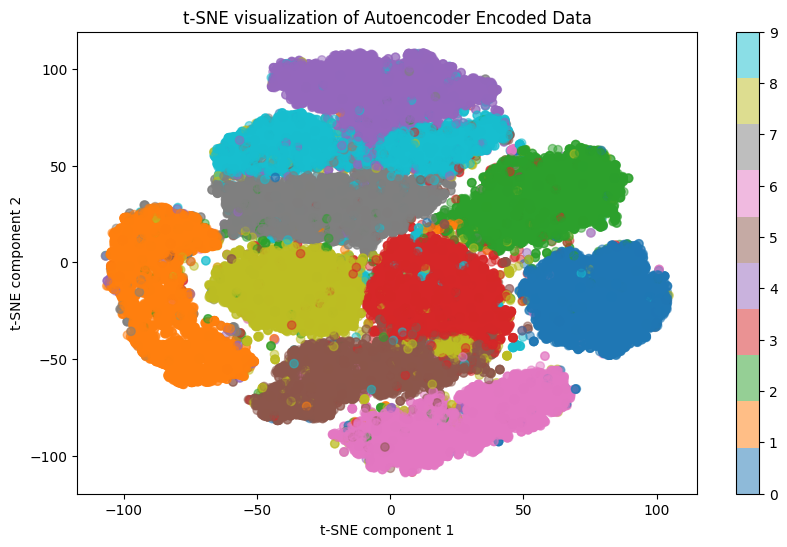

In [116]:
show_tsne(train_images, og_train_labels, encoder)

#### Classification score, reconstruction error and manifold convergence

In [110]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(x_train_noisy, verbose=0)
encoded_test_images = encoder.predict(x_test_noisy, verbose=0)

test_loss, test_accuracy = log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8496 - loss: 0.4869
Test accuracy: 0.8718000054359436, Test loss: 0.41687899827957153


In [9]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(x_test_noisy, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

W0000 00:00:1715794555.223513     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715794555.762105     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Reconstruction error: 0.014021438546478748


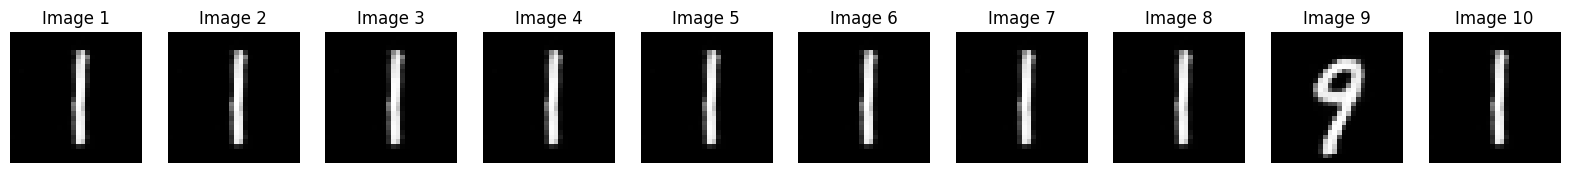

In [10]:
convergence(autoencoder)

random noise seems to be converging to digit 1 and digit 9 most of the time

In [11]:
result_data = {
    'Model': '2 layers (256, 128) DAE', 
    'Training Loss': history.history['loss'][-1], 
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss, 
    'Test Accuracy': test_accuracy, 
    'Reconstruction Error': reconstruction_error, 
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

/tmp/ipykernel_34/4129495804.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, new_row], ignore_index=True)


### Greedy Unsupervised Layerwise Pretraining
As anticipated above, we are now implementing the GULP strategy to train deep autoencoders (each one composed of a single layer). In this case, given the simpplicity of the dataset we are going to use just two autoencoders (one with a layer of 256 units and one with a layer of 128, in order to match the structure of the previous built autoencoder).

In [12]:
training_time, history, autoencoder, encoder = gulp(train_images, 784, [256, 128], x_train_noisy)

W0000 00:00:1715794613.431703     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715794614.166643     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 31.
Restoring model weights from the end of the best epoch: 50.


In [13]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(x_train_noisy, verbose=0)
encoded_test_images = encoder.predict(x_test_noisy, verbose=0)

test_loss, test_accuracy = log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8346 - loss: 0.5053
Test accuracy: 0.8544999957084656, Test loss: 0.44932499527931213


In [14]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(x_test_noisy, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

W0000 00:00:1715794681.926258     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Reconstruction error: 0.05566508322954178


W0000 00:00:1715794682.405765     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


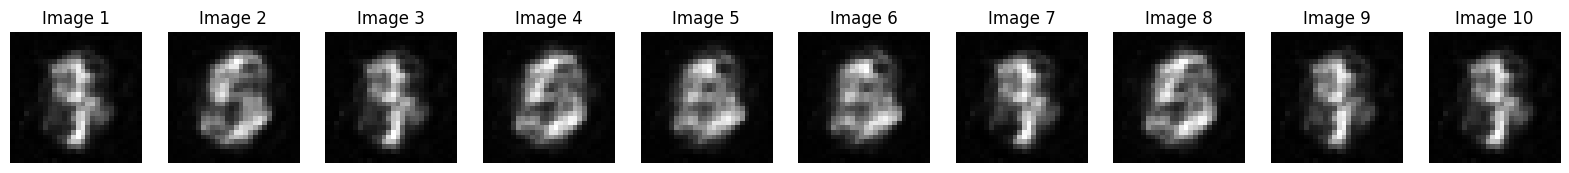

In [15]:
convergence(autoencoder)

The pre-training did not end up with a significant representation of the data, though as we can see from the image, it seems to be getting a grasp on where most digits are located –i.e. in the center of the image.

To improve the perfomance, we are now fine-tuning the model, precisely we are let the model train for some other epochs until it starts to overfit (using early stopping to prevent it). Notice that the weights do not reset, rather they are set from the pre-training.

In [ ]:
show_tsne(train_images, og_train_labels, encoder)

In [16]:
result_data = {
    'Model': 'GULP 2 layers (256, 128) DAE (pre-training)', 
    'Training Loss': history.history['loss'][-1], 
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss, 
    'Test Accuracy': test_accuracy, 
    'Reconstruction Error': reconstruction_error, 
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

In [17]:
# fine-tuning the full autoencoder
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
start_time = time.time()
history = autoencoder.fit(x_train_noisy, train_images, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)
training_time = time.time() - start_time

W0000 00:00:1715794740.328852     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715794741.369936     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 40.


In [18]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(x_train_noisy, verbose=0)
encoded_test_images = encoder.predict(x_test_noisy, verbose=0)

test_loss, test_accuracy = log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8520 - loss: 0.4578
Test accuracy: 0.8694999814033508, Test loss: 0.40261414647102356


In [19]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(x_test_noisy, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction error: 0.016906417906284332


The accuracy did improve significantly w.r.t. the pre-trained model, but just a little in comparison to the previous auto-encoder, the one that has been trained without GULP.

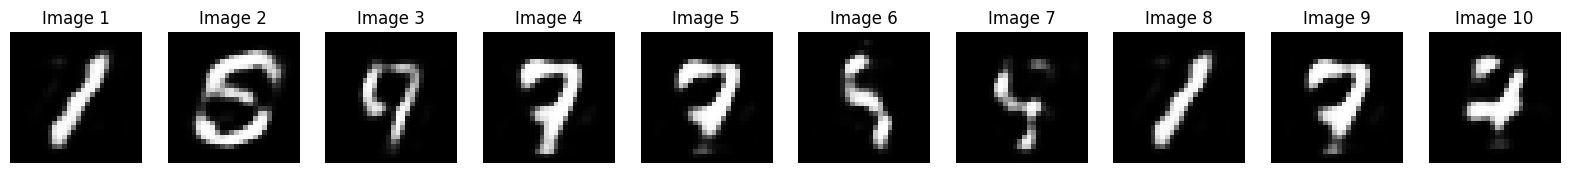

In [20]:
convergence(autoencoder)

Once again, the model seems to have learned a representation of the data as the random noise image converges to some digits, specifically 9 and 1 (same as before).

In [ ]:
show_tsne(train_images, og_train_labels, encoder)

In [21]:
result_data = {
    'Model': 'GULP 2 layers (256, 128) DAE (fine-tuning)', 
    'Training Loss': history.history['loss'][-1], 
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss, 
    'Test Accuracy': test_accuracy, 
    'Reconstruction Error': reconstruction_error, 
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

In [22]:
df_result

,Model,Training Loss,Validation Loss,Test Loss,Test Accuracy,Reconstruction Error,Training Time
0,"2 layers (256, 128) DAE",0.012762,0.014353,0.426420,0.8639,0.014021,26.544548
1,"GULP 2 layers (256, 128) DAE (pre-training)",2.094377,2.083194,0.449325,0.8545,0.055665,47.190894
2,"GULP 2 layers (256, 128) DAE (fine-tuning)",0.013968,0.017203,0.402614,0.8695,0.016906,26.923749


### Using a U-Shaped CNN as encoder-decoder structure
Since we are dealing with images, we will now see whether using a U-Shaped CNN gives us any conspicuous advantage. We will restrict ourselves to just explore a simple structure of two convolutions/deconvolutions (where we will use maxpooling to downsample and a strided deconvolution to upsample).

In [23]:
(train_images_2D, _), (test_images_2D, _) = mnist.load_data()

train_images_2D = train_images_2D.astype('float32') / 255.
test_images_2D = test_images_2D.astype('float32') / 255.

train_images_2D = np.reshape(train_images_2D, (len(train_images_2D), 28, 28, 1))
test_images_2D = np.reshape(test_images_2D, (len(test_images_2D), 28, 28, 1))

x_train_noisy_2D = add_noise(train_images_2D)
x_test_noisy_2D = add_noise(test_images_2D)

In [24]:
input_img = K.layers.Input(shape=(28, 28, 1))
# encoder
x = K.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = K.layers.MaxPooling2D((2, 2), padding='same')(x)
x = K.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = K.layers.MaxPooling2D((2, 2), padding='same')(x)

# decoder
x = K.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = K.layers.UpSampling2D((2, 2))(x)
x = K.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = K.layers.UpSampling2D((2, 2))(x)
decoded = K.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = K.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
start_time = time.time()
history = autoencoder.fit(x_train_noisy_2D, train_images_2D, epochs=50, batch_size=128, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)
training_time = time.time() - start_time

Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 42.


In [25]:
# extracting the encoder part from the trained autoencoder
autoencoder_input = K.layers.Input(shape=(28, 28, 1))
x = autoencoder.layers[1](autoencoder_input)  # first Conv2D layer
x = autoencoder.layers[2](x)  # first MaxPooling2D layer
x = autoencoder.layers[3](x)  # second Conv2D layer
encoded_output = autoencoder.layers[4](x)  # second MaxPooling2D layer

# logistic regressor
flatten = K.layers.Flatten()(encoded_output)
dense = K.layers.Dense(128, activation='relu')(flatten)
classifier_output = K.layers.Dense(10, activation='softmax')(dense)
classifier_model = K.Model(autoencoder_input, classifier_output)

classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier_model.fit(x_train_noisy_2D, train_labels, epochs=30, batch_size=256, validation_split=0.2, verbose=0)

test_loss, test_accuracy = classifier_model.evaluate(x_test_noisy_2D, test_labels, verbose=0)
print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')

W0000 00:00:1715794938.241494     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715794940.041737     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715794940.709051     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715794941.699652     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715794967.223911     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test accuracy: 0.9685999751091003, Test loss: 0.1898556649684906


W0000 00:00:1715794968.201364     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [26]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(x_test_noisy_2D, verbose=0), test_images_2D).numpy()
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction error: 0.025481581687927246


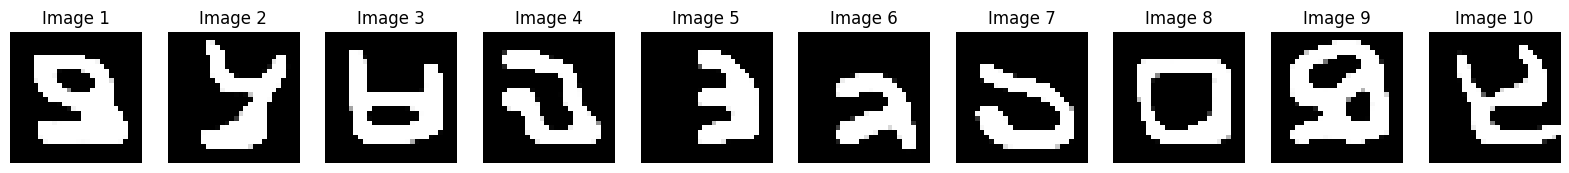

In [27]:
convergence(autoencoder, conv=True)

The accuracy surely gets better than the previous models, but the reconstructions are the weirdest looking ones so far.

In [28]:
result_data = {
    'Model': 'CNN 2 conv_layers DAE', 
    'Training Loss': history.history['loss'][-1], 
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss, 
    'Test Accuracy': test_accuracy, 
    'Reconstruction Error': reconstruction_error, 
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

In [ ]:
show_tsne(train_images_2D, og_train_labels, encoder)

# Contractive Auto Encoder
Up to now, we have limited ourselves to using a noising process to determine our training.

CAEs act similar to DAEs but with a slight difference: the formers specifically penalize the derivative of the hidden representation with respect to the input – meaning how much the internal representation changes in response to small changes in the input (focusing on the stability and robustness of the features themselves); while the latters focus on recovering an accurate, denoised version of the input from a deliberately corrupted version, thus encouraging the model to learn the more stable, structural characteristics of the data rather than noise.


In [106]:
(train_images, og_train_labels), (test_images, og_test_labels) = mnist.load_data()

# reshape images to 1D
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 784))
test_images = test_images.reshape((len(test_images), 784))

train_labels = K.utils.to_categorical(og_train_labels, 10)
test_labels = K.utils.to_categorical(og_test_labels, 10)

In [30]:
# setting up the model
input_img = K.layers.Input(shape=(784,))
encoded = K.layers.Dense(256, activation='sigmoid')(input_img)
encoded = K.layers.Dense(128, activation='sigmoid')(encoded)
decoded = K.layers.Dense(256, activation='sigmoid')(encoded)
decoded = K.layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = K.Model(input_img, decoded)
encoder = K.Model(input_img, encoded)

custom_loss = contractive_loss(encoder, sigmoid_flag=True)
autoencoder.compile(optimizer='adam', loss=custom_loss)

# autoencoder's training
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
start_time = time.time()
history = autoencoder.fit(train_images, train_images, epochs=30, batch_size=32, shuffle=True, validation_split=0.2, verbose=0, callbacks=[early_stopping])
training_time = time.time() - start_time

W0000 00:00:1715795029.978628     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715795032.757508     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Restoring model weights from the end of the best epoch: 30.


In [31]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(train_images, verbose=0)
encoded_test_images = encoder.predict(test_images, verbose=0)

test_loss, test_accuracy = log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Restoring model weights from the end of the best epoch: 48.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9015 - loss: 0.3397
Test accuracy: 0.9157000184059143, Test loss: 0.2975037395954132


In [32]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(test_images, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

W0000 00:00:1715795148.972518     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Reconstruction error: 0.0037586200051009655


W0000 00:00:1715795149.453556     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


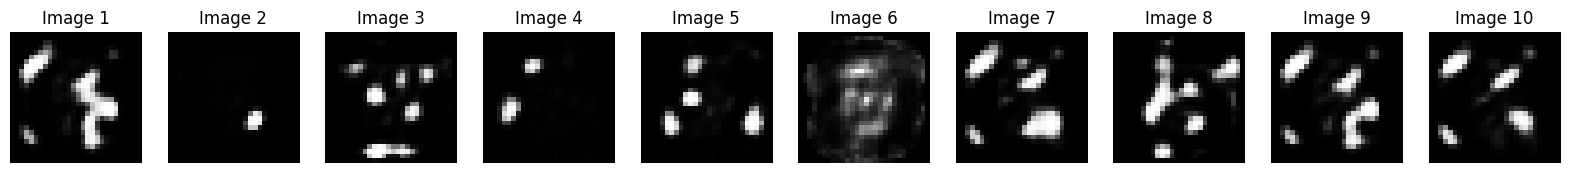

In [33]:
convergence(autoencoder)

In [ ]:
show_tsne(train_images, og_train_labels, encoder)

In [34]:
result_data = {
    'Model': '2 layers (256, 128) CAE', 
    'Training Loss': history.history['loss'][-1], 
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss, 
    'Test Accuracy': test_accuracy, 
    'Reconstruction Error': reconstruction_error, 
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

In [35]:
training_time, history, autoencoder, encoder = gulp(train_images, 784, [256, 128], hidden_act='sigmoid', cae_flag=True, epochs=20)

W0000 00:00:1715795207.509656     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715795208.386452     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715795208.956332     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Restoring model weights from the end of the best epoch: 20.
Restoring model weights from the end of the best epoch: 20.


In [36]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(train_images, verbose=0)
encoded_test_images = encoder.predict(test_images, verbose=0)

test_loss, test_accuracy = log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Restoring model weights from the end of the best epoch: 49.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9020 - loss: 0.3428
Test accuracy: 0.9153000116348267, Test loss: 0.2984449565410614


In [37]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(test_images, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

W0000 00:00:1715795274.311593     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Reconstruction error: 0.006349072325974703


W0000 00:00:1715795274.805320     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


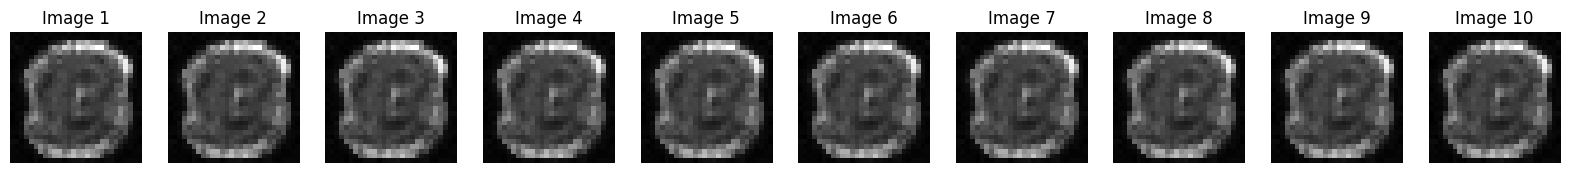

In [38]:
convergence(autoencoder, n_img=10)

In [ ]:
show_tsne(train_images, og_train_labels, encoder)

In [39]:
result_data = {
    'Model': 'GULP 2 layers (256, 128) CAE (pre-training)', 
    'Training Loss': history.history['loss'][-1], 
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss, 
    'Test Accuracy': test_accuracy, 
    'Reconstruction Error': reconstruction_error, 
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

In [40]:
# fine-tuning the full autoencoder
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
start_time = time.time()
history = autoencoder.fit(train_images, train_images, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)
training_time = time.time() - start_time

W0000 00:00:1715795332.975950     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715795334.166951     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715795334.817016     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 44.


In [41]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(train_images, verbose=0)
encoded_test_images = encoder.predict(test_images, verbose=0)

test_loss, test_accuracy = log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Restoring model weights from the end of the best epoch: 50.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8934 - loss: 0.3889
Test accuracy: 0.9077000021934509, Test loss: 0.3404102325439453


In [42]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(test_images, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction error: 0.0034712948836386204


The accuracy did improve significantly w.r.t. the pre-trained model, but just a little in comparison to the previous auto-encoder, the one that has been trained without GULP.

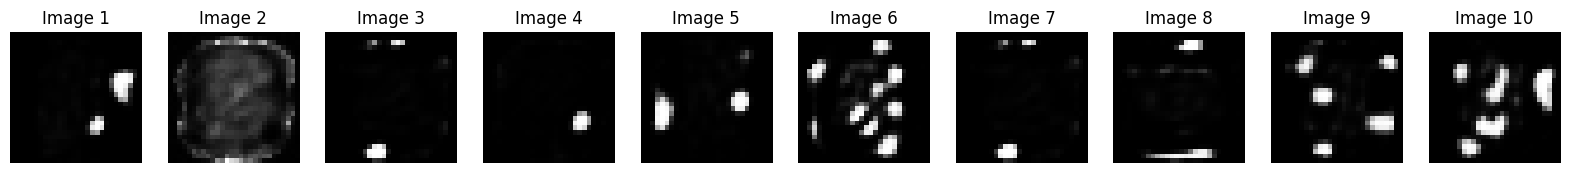

In [43]:
convergence(autoencoder)

In [ ]:
show_tsne(train_images, og_train_labels, encoder)

In [44]:
result_data = {
    'Model': 'GULP 2 layers (256, 128) CAE (fine-tuning)', 
    'Training Loss': history.history['loss'][-1], 
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss, 
    'Test Accuracy': test_accuracy, 
    'Reconstruction Error': reconstruction_error, 
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

In [45]:
df_result

,Model,Training Loss,Validation Loss,Test Loss,Test Accuracy,Reconstruction Error,Training Time
0,"2 layers (256, 128) DAE",0.012762,0.014353,0.426420,0.8639,0.014021,26.544548
1,"GULP 2 layers (256, 128) DAE (pre-training)",2.094377,2.083194,0.449325,0.8545,0.055665,47.190894
2,"GULP 2 layers (256, 128) DAE (fine-tuning)",0.013968,0.017203,0.402614,0.8695,0.016906,26.923749
3,CNN 2 conv_layers DAE,0.092749,0.094953,0.189856,0.9686,0.025482,87.958581
4,"2 layers (256, 128) CAE",0.004722,0.004915,0.297504,0.9157,0.003759,83.001899
5,"GULP 2 layers (256, 128) CAE (pre-training)",0.002942,0.002882,0.298445,0.9153,0.006349,30.347631
6,"GULP 2 layers (256, 128) CAE (fine-tuning)",0.003859,0.004089,0.340410,0.9077,0.003471,29.402478


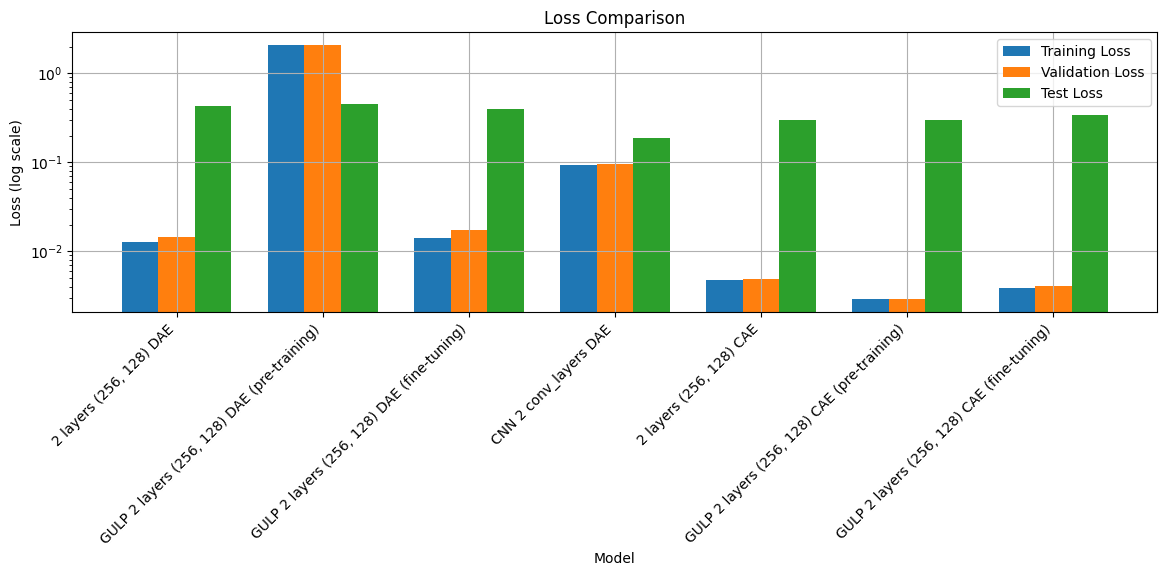

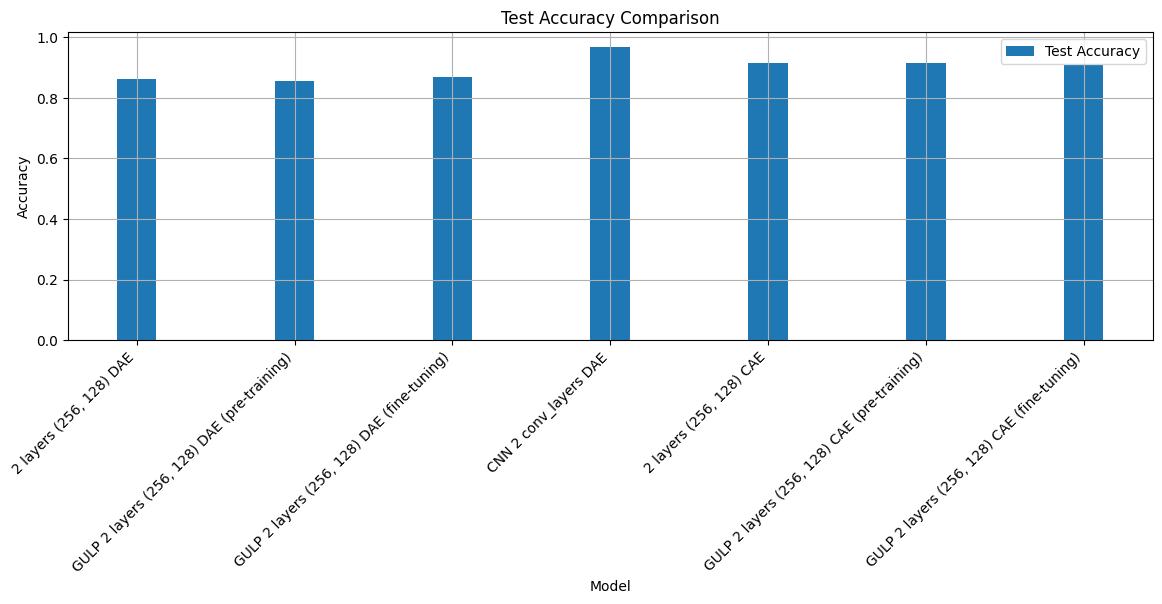

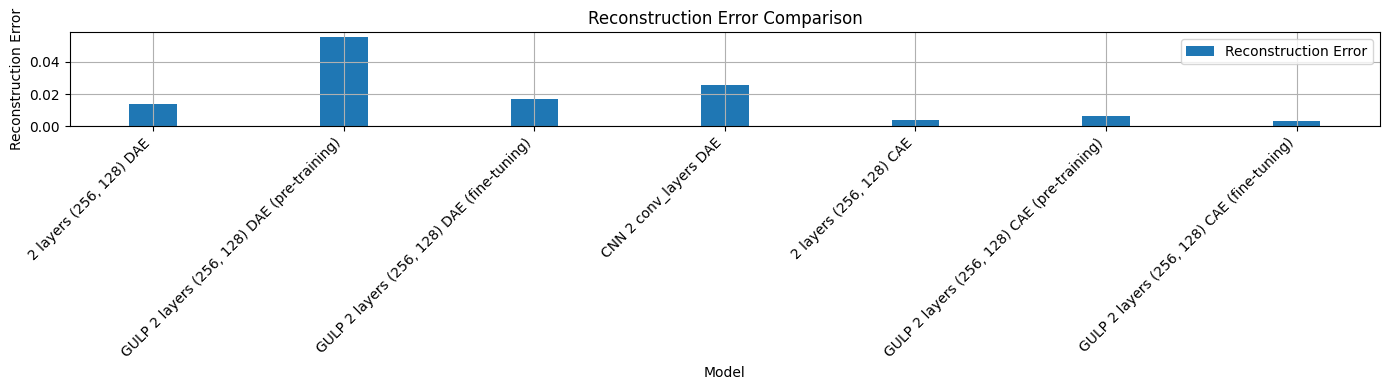

In [123]:
# Plotting
plt.figure(figsize=(14, 8))

# Bar plot for Training, Validation, and Test Loss with logarithmic scale
plt.subplot(2, 1, 1)
bar_width = 0.25
index = range(len(df))

plt.bar(index, df['Training Loss'], bar_width, label='Training Loss')
plt.bar([i + bar_width for i in index], df['Validation Loss'], bar_width, label='Validation Loss')
plt.bar([i + 2 * bar_width for i in index], df['Test Loss'], bar_width, label='Test Loss')

plt.yscale('log')
plt.xlabel('Model')
plt.ylabel('Loss (log scale)')
plt.title('Loss Comparison')
plt.xticks([i + bar_width for i in index], df['Model'], rotation=45, ha='right')
plt.legend()
plt.grid(True)

# Separate plot for Test Accuracy
plt.figure(figsize=(14, 4))
plt.bar(index, df['Test Accuracy'], bar_width, label='Test Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')
plt.xticks(index, df['Model'], rotation=45, ha='right')
plt.legend()
plt.grid(True)

# Separate plot for Reconstruction Error
plt.figure(figsize=(14, 4))
plt.bar(index, df['Reconstruction Error'], bar_width, label='Reconstruction Error')
plt.xlabel('Model')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Comparison')
plt.xticks(index, df['Model'], rotation=45, ha='right')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()